In [1]:
# imports
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import timeit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%timeit
from IPython.display import Latex

In [2]:
# load list of pulsar names
pulsar_names = np.loadtxt('classic_psrs.txt', dtype=np.unicode_)
n_psrs = len(pulsar_names)

In [3]:
# save Tspan, calc freqs
Tspan = 952746385.6296968 # s
inv_T = 1/Tspan
freq = np.arange(1,6)*inv_T

In [120]:
rho_freq = {rho: f for rho, f in zip(rho_labels, freq)}

In [4]:
pulsar_names

array(['J0030+0451', 'J0034-0534', 'J0218+4232', 'J0437-4715',
       'J0610-2100', 'J0613-0200', 'J0621+1002', 'J0711-6830',
       'J0751+1807', 'J0900-3144', 'J1012+5307', 'J1022+1001',
       'J1024-0719', 'J1045-4509', 'J1455-3330', 'J1600-3053',
       'J1603-7202', 'J1614-2230', 'J1640+2224', 'J1643-1224',
       'J1713+0747', 'J1721-2457', 'J1730-2304', 'J1732-5049',
       'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1751-2857',
       'J1801-1417', 'J1802-2124', 'J1804-2717', 'J1824-2452A',
       'J1843-1113', 'J1853+1303', 'J1857+0943', 'J1903+0327',
       'J1909-3744', 'J1910+1256', 'J1911+1347', 'J1911-1114',
       'J1918-0642', 'J1939+2134', 'J1944+0907', 'J1955+2908',
       'J2010-1323', 'J2019+2425', 'J2033+1734', 'J2124-3358',
       'J2129-5721', 'J2145-0750', 'J2229+2643', 'J2317+1439',
       'J2322+2057'], dtype='<U11')

In [5]:
# associate each pulsar to correct output dir
outdirs = dict(zip(pulsar_names, ['results/psr_'+str(i) for i in range(n_psrs)]))

In [6]:
# load list of parameter labels to dict corresponding to each psr. Also adds in metadata par labels
metadata_pars = ['log-likelihood', 'unweighted log-posterior', 'MCMC acceptance rate', 'interchain transitions acceptance rate']
pars = {psr : np.append(np.loadtxt(outdirs[psr] + '/pars.txt', dtype=np.unicode_),metadata_pars) for psr in pulsar_names}

In [7]:
# plot violin plots of gw_log10_rho comps for each psr
rho_labels = ['gw_log10_rho_0', 'gw_log10_rho_1', 'gw_log10_rho_2', 'gw_log10_rho_3', 'gw_log10_rho_4',]

In [8]:
# load chain data to dict for each psr. Calc burn-in cut-off for each psr
chains = {psr : pd.read_csv(outdirs[psr] + '/chain_1.txt', sep='\t', dtype=float, header=None, names=pars[psr], error_bad_lines=False) for psr in pulsar_names}
burns = {psr : int(0.25*chains[psr].shape[0]) for psr in pulsar_names}

In [9]:
pars['J0030+0451']

array(['J0030+0451_dm_gp_gamma', 'J0030+0451_dm_gp_log10_A',
       'J0030+0451_red_noise_gamma', 'J0030+0451_red_noise_log10_A',
       'gw_log10_rho_0', 'gw_log10_rho_1', 'gw_log10_rho_2',
       'gw_log10_rho_3', 'gw_log10_rho_4', 'log-likelihood',
       'unweighted log-posterior', 'MCMC acceptance rate',
       'interchain transitions acceptance rate'], dtype='<U38')

# Producing violin plots

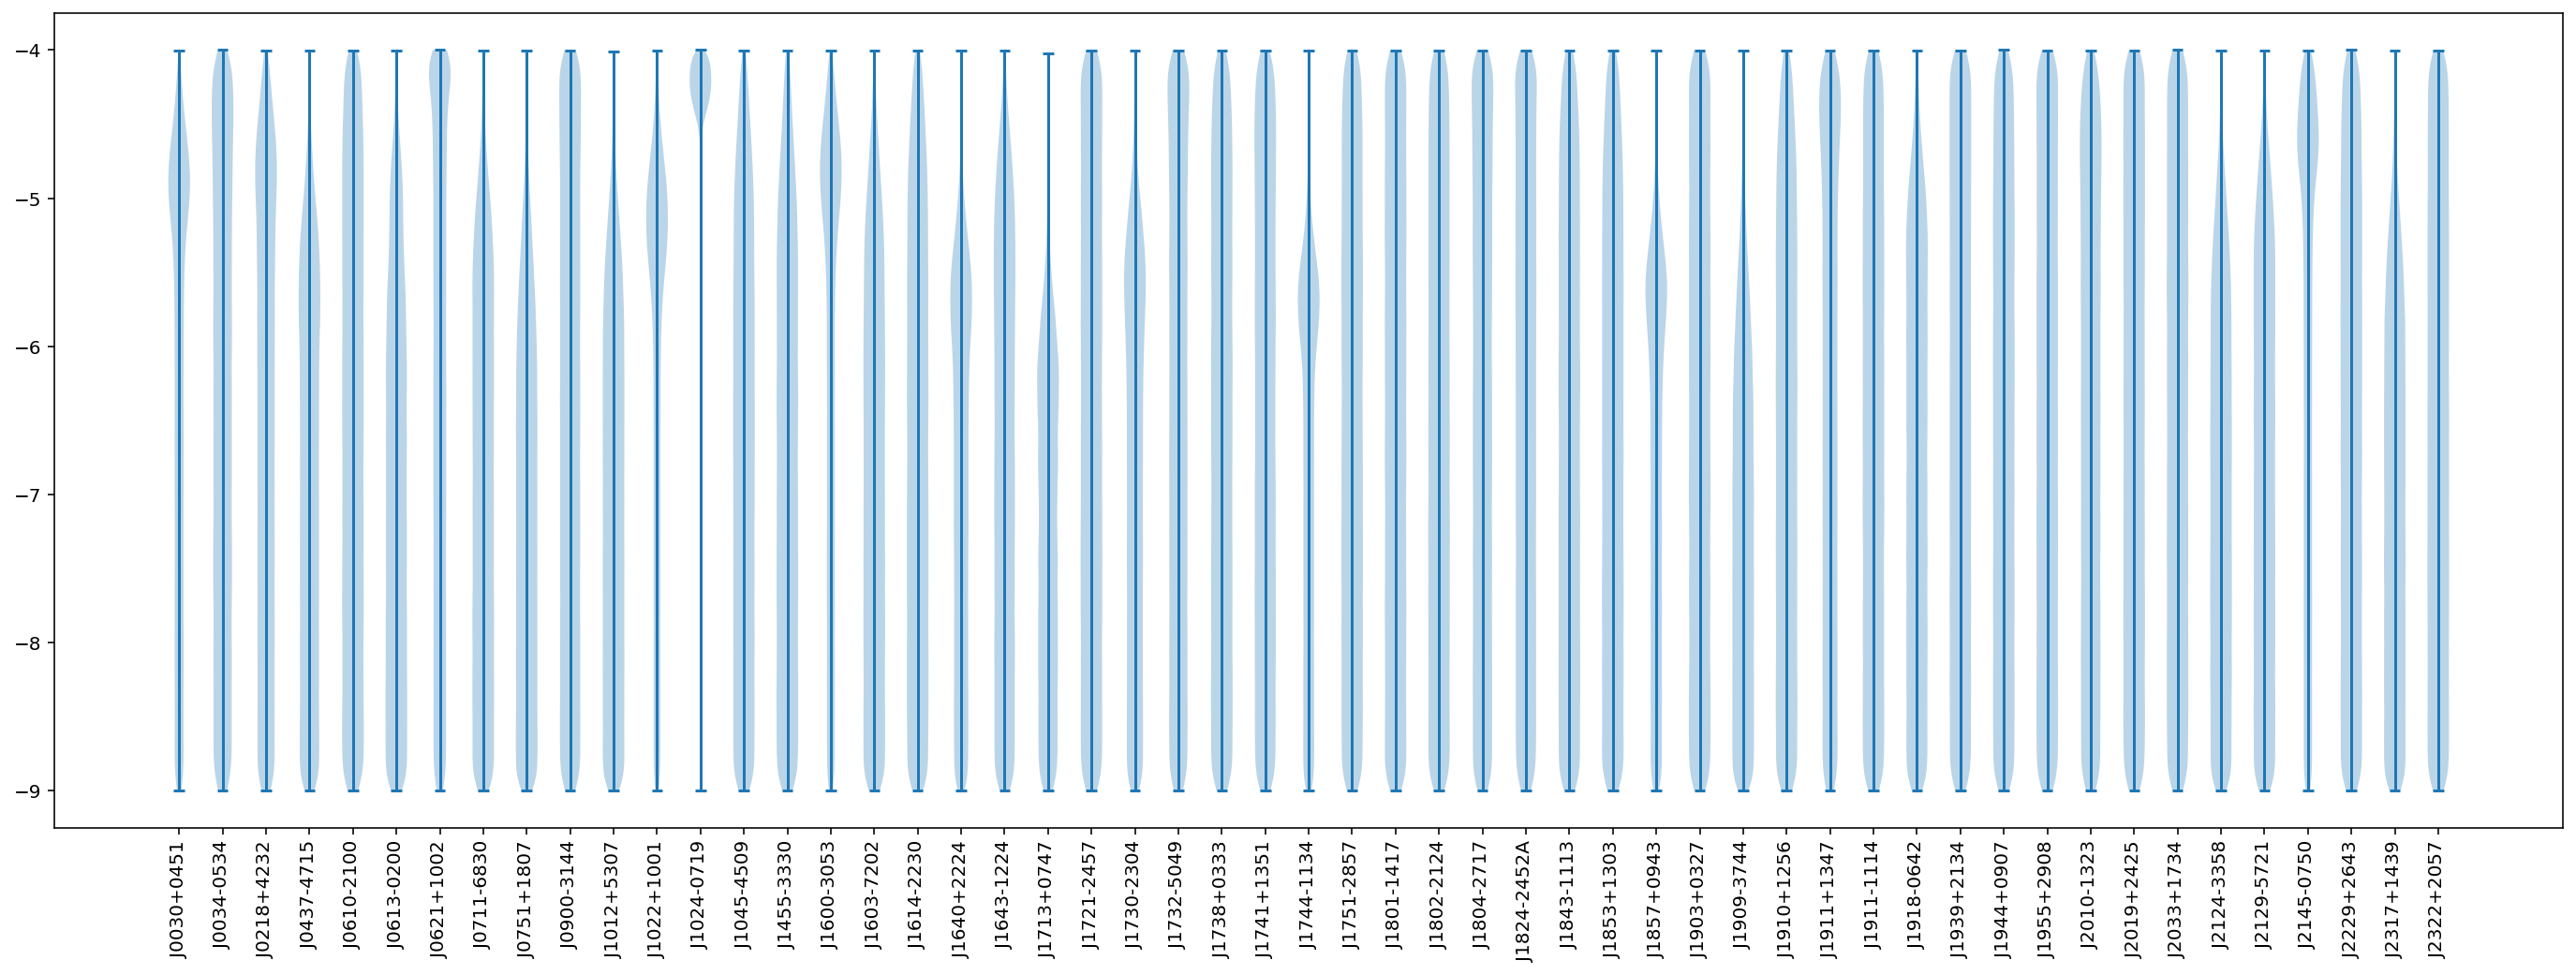

In [9]:
rho = [chains[psr]['gw_log10_rho_0'][burns[psr]:] for psr in pulsar_names]
plt.figure(figsize=(24,8))
plt.violinplot(rho)
plt.xticks(np.arange(1,n_psrs+1), pulsar_names, rotation='vertical')
plt.show()

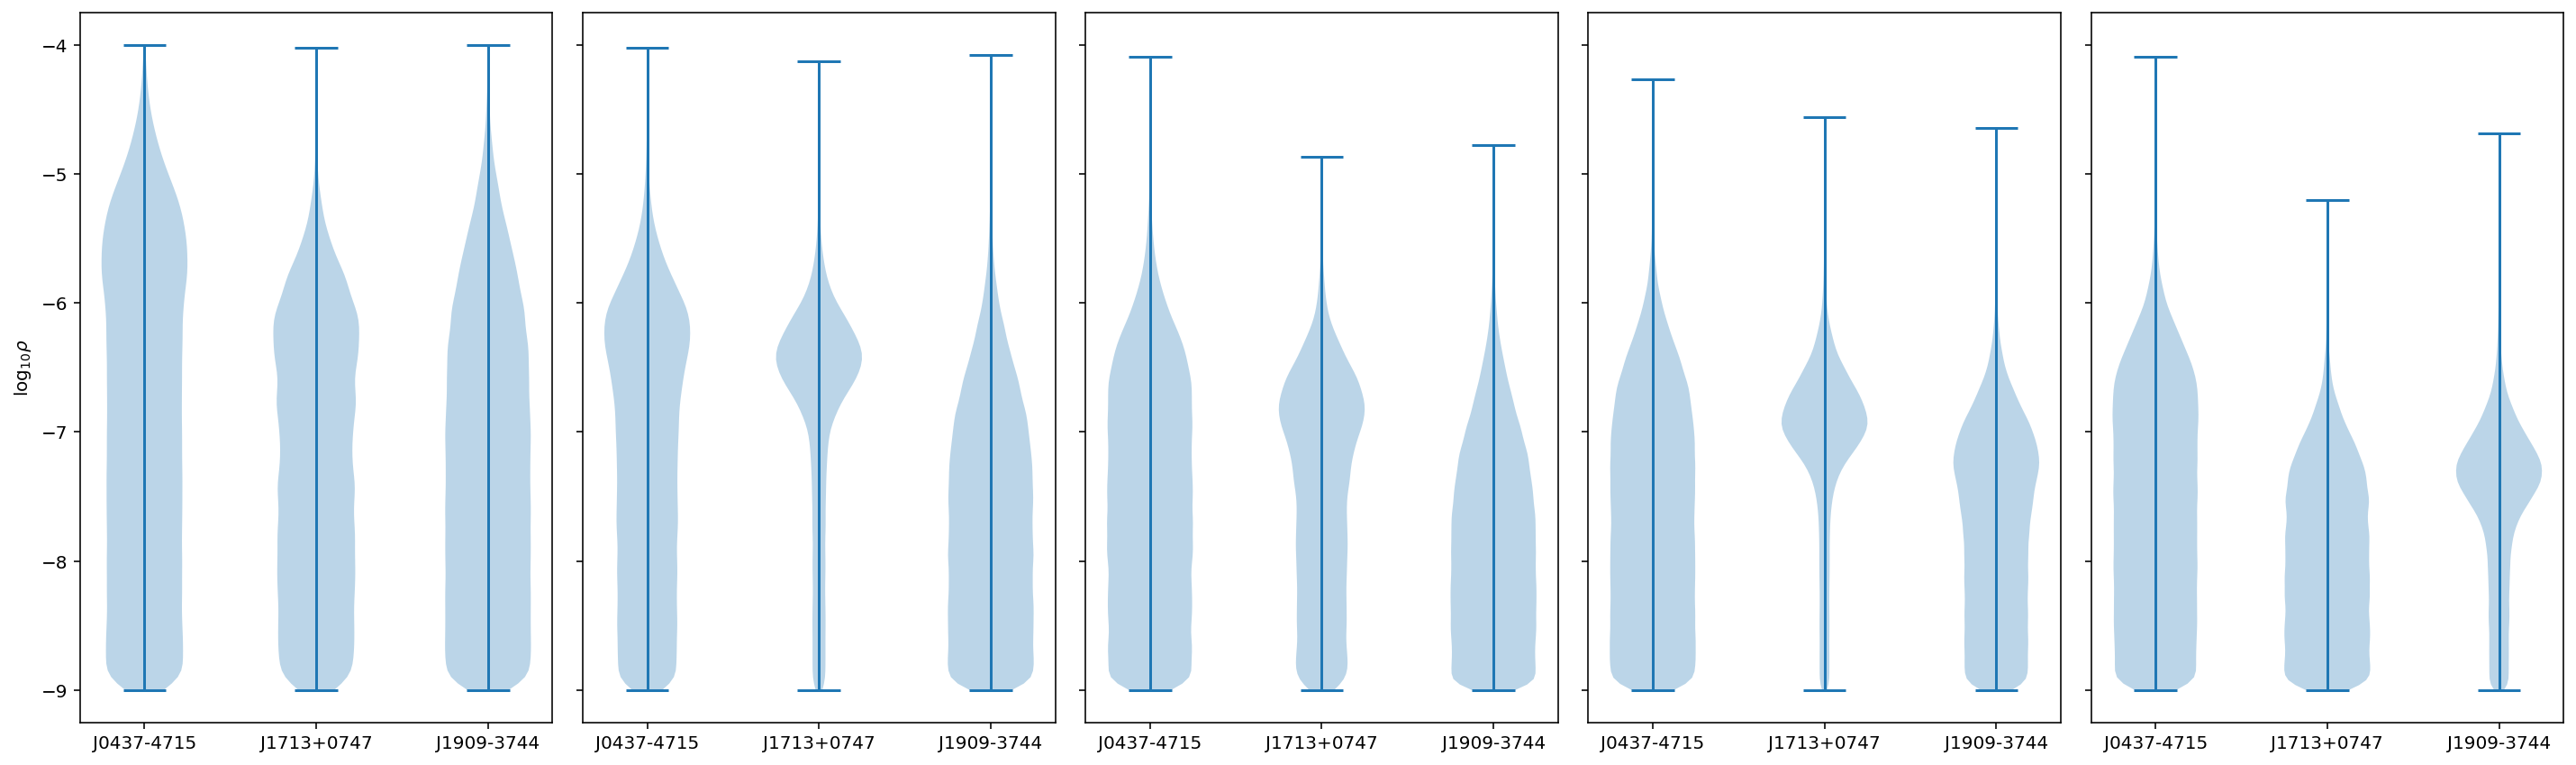

In [10]:
# same as above, but only for slice of psrs
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,6), tight_layout=True, sharey=True)
chosen_psrs = ['J0437-4715','J1713+0747','J1909-3744']

for ii in range(5):
    ax = axs[ii]
    rho = [chains[psr][rho_labels[ii]][burns[psr]:] for psr in chosen_psrs]
    ax.violinplot(rho)
    ax.set_xticks(np.arange(1,4))
    ax.set_xticklabels(chosen_psrs)
axs[0].set_ylabel(r'$\log_{10} \rho$')
plt.show()

# Multiplying histograms

In [10]:
# common set of bins across all psrs
rho_bins = np.linspace(-9, -4, num=50, endpoint=True)

In [11]:
# multiply histograms of each psr for each rho. Save to dict corresponding to each rho
epsilon = 1e-20 # add this somehow!
histograms = {rho : np.prod([np.histogram(chains[psr][rho][burns[psr]:], rho_bins, density=True)[0]+epsilon for psr in pulsar_names], axis=0) for rho in rho_labels}

In [12]:
# generate distribution from each rho histogram
bin_mid = (rho_bins[1:] + rho_bins[:-1]) / 2.0
rvhist = {rho : scipy.stats.rv_histogram([histograms[rho], rho_bins]) for rho in rho_labels}

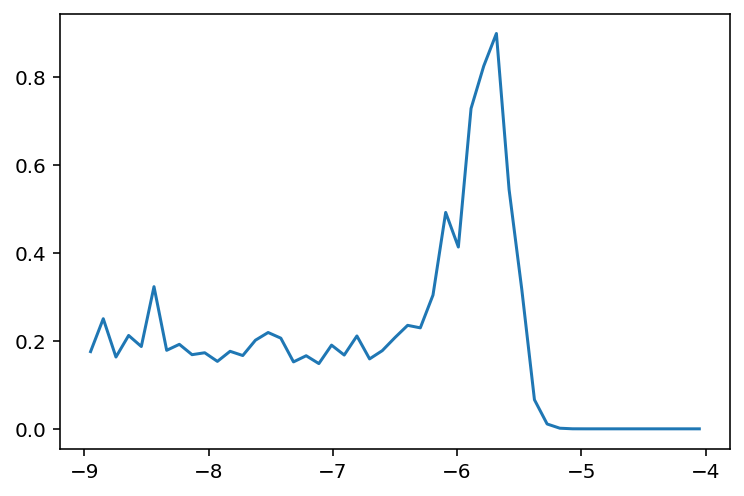

In [228]:
plt.plot(bin_mid, rvhist['gw_log10_rho_0'].pdf(bin_mid), label='PDF')
plt.show()

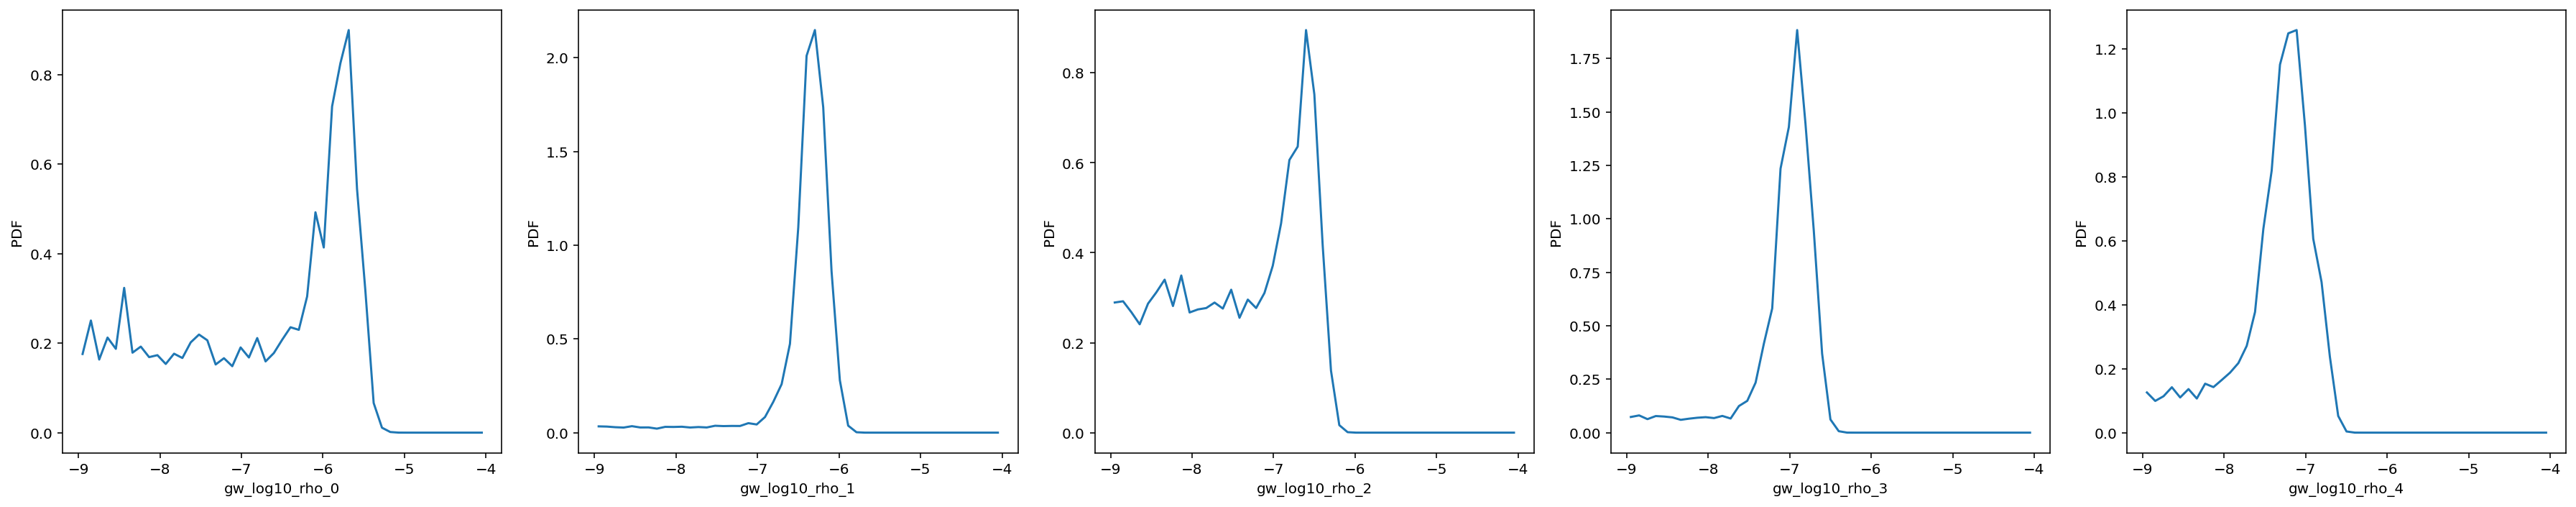

In [229]:
# plot distributions for each rho component
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25,5), tight_layout=True)

for ii in range(5):
    ax = axs[ii]
    ax.plot(bin_mid, rvhist[rho_labels[ii]].pdf(bin_mid), label='PDF')
    ax.set_xlabel(rho_labels[ii])
    ax.set_ylabel('PDF')

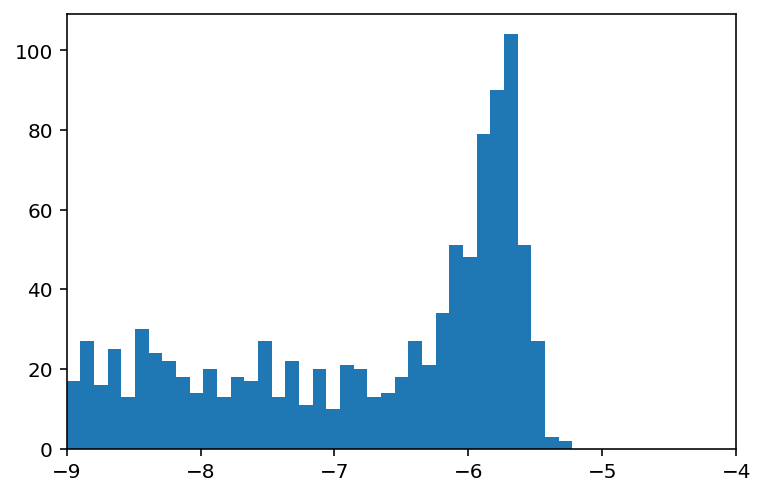

In [230]:
# draw samples from distributions
rvs_rho_0 = rvhist['gw_log10_rho_0'].rvs(size=1000)
plt.hist(rvs_rho_0, rho_bins)
plt.xlim(-9,-4)
plt.show()

In [13]:
# function to calculate powerlaw at each frequency
def powerlaw(freqs, log10_A, gamma):
    fyr = 1.0 / 365.25 / 86400.0
    log10_A = log10_A
    gamma = gamma
    plaw = 10**(2.0 * log10_A) * (freqs / fyr)**(-gamma) / 12.0 / np.pi**2.0
    plaw /= fyr**3.0 # psd usually given in units = (year)^3; this corrects that
    plaw *= freqs[0] # this multiplies by Tspan, which is the zeroth frequnecy here
    return 0.5 * np.log10(plaw)

In [14]:
params = [np.log10(2.2e-15), 4.333] # spectral index, gamma
log10_f = np.log10(freq)

In [233]:
pl = powerlaw(freq, *params)

In [234]:
# draw 1000 from histograms for each rho
rv_samples = [rvhist[rho].rvs(size=100000) for rho in rho_labels]

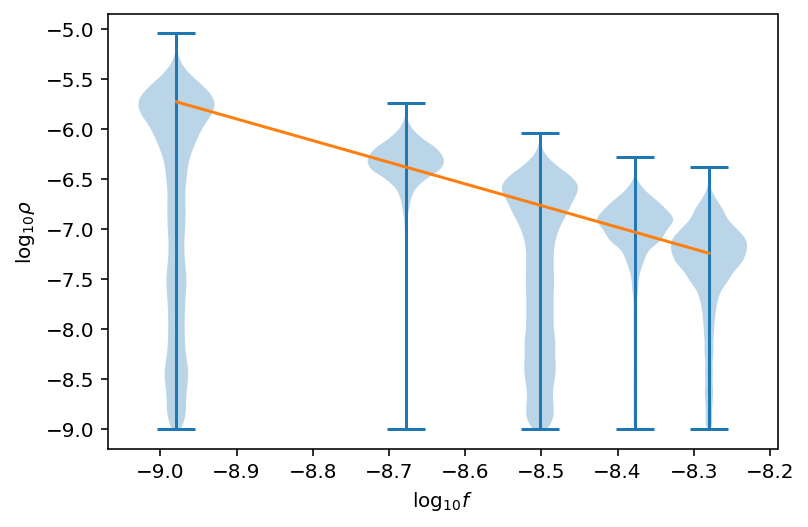

In [235]:
# overplot powerlaw on violinplot of random samples
plt.violinplot(rv_samples, positions=log10_f, widths=0.1)
plt.plot(np.log10(freq), pl)
plt.xlabel(r'$\log_{10} f$')
plt.ylabel(r'$\log_{10} \rho$')
plt.show()

# Fitting a powerlaw

In [236]:
rv_samples

[array([-5.69839113, -5.73596892, -5.9307368 , ..., -8.80416593,
        -5.68545311, -5.59810199]),
 array([-6.31304484, -6.7048393 , -6.18475323, ..., -6.48938691,
        -6.39710533, -6.17049971]),
 array([-6.90219952, -6.69934114, -6.92122724, ..., -6.59078534,
        -8.15038646, -6.53195988]),
 array([-6.94404729, -6.88896276, -7.21182476, ..., -8.95584557,
        -7.29723601, -6.50959847]),
 array([-7.03435065, -7.6449207 , -7.21335783, ..., -7.39080963,
        -7.42494586, -6.74605264])]

In [237]:
samp_mean = np.mean(rv_samples, axis=1)
samp_std  = np.std(rv_samples, axis=1)

In [238]:
samp_mean

array([-6.77168633, -6.44039951, -7.4339315 , -7.09926819, -7.39704085])

In [239]:
samp_std

array([1.09759952, 0.45733069, 0.80736668, 0.4651776 , 0.50309134])

In [240]:
p0 = [np.log10(2.5e-15), 4.333]
pars, cov = curve_fit(f=powerlaw, xdata=freq, ydata=samp_mean, p0=p0, sigma=samp_std, absolute_sigma=False)

In [241]:
perr = np.sqrt(np.diag(cov))
perr

array([0.72504791, 1.43836599])

In [242]:
fit = powerlaw(freq, *pars)

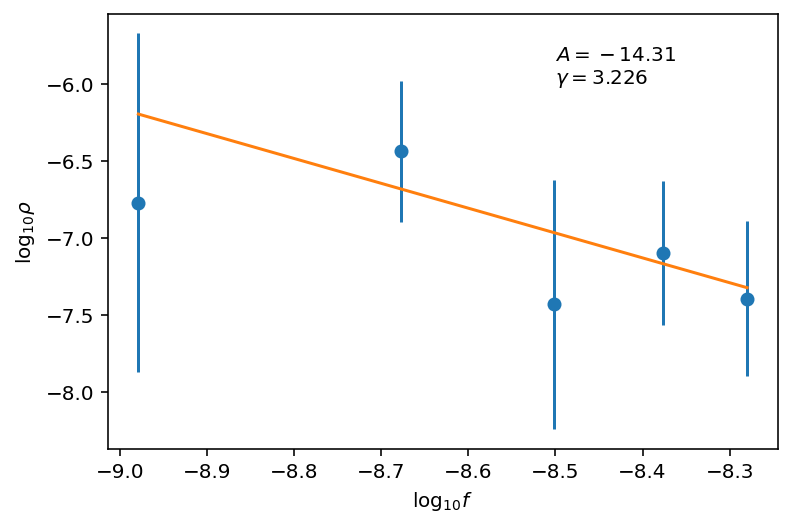

In [243]:
# overplot powerlaw on violinplot of random samples drawn from histrogram distributions for each rho
plt.errorbar(log10_f, samp_mean, yerr=samp_std, fmt='o')
plt.plot(np.log10(freq), fit)
plt.xlabel(r'$\log_{10} f$')
plt.ylabel(r'$\log_{10} \rho$')
plt.annotate(f'$A={pars[0]:.2f}$\n$\gamma={pars[1]:.3f}$', xy=(-8.5,-6), xycoords='data')
plt.show()

# Hist logpdf

In [15]:
# array of rhos, need to do this for various A, gamma!
num = 101
gammas = np.linspace(0, 7, num)
log10_As = np.linspace(-16., -12.5, num)

In [245]:
# 2d array of the sum of logrho over frequencies for various log10A, gamma
# columns = gamma, rows = log10A
logrho = [np.vstack([powerlaw(freq, aa, gg) for gg in gammas]) for aa in log10_As]

In [246]:
logrho_sumfreq = np.sum(logrho, axis=2)
logrho_sumfreq

array([[-51.387866  , -51.20165951, -51.01545302, ..., -33.13962984,
        -32.95342335, -32.76721686],
       [-51.212866  , -51.02665951, -50.84045302, ..., -32.96462984,
        -32.77842335, -32.59221686],
       [-51.037866  , -50.85165951, -50.66545302, ..., -32.78962984,
        -32.60342335, -32.41721686],
       ...,
       [-34.237866  , -34.05165951, -33.86545302, ..., -15.98962984,
        -15.80342335, -15.61721686],
       [-34.062866  , -33.87665951, -33.69045302, ..., -15.81462984,
        -15.62842335, -15.44221686],
       [-33.887866  , -33.70165951, -33.51545302, ..., -15.63962984,
        -15.45342335, -15.26721686]])

In [247]:
## A certain (A,gamma) defines powerlaw rho values at all frequencies
## Put the rho for each frequency into the logpdf function for that frequency
## sum over frequencies

log_likely = [[[rvhist[rho_labels[jj]].logpdf(logrho[aa][gg][jj]) for jj in range(5)] for gg in range(num)] for aa in range(num)]

/Users/lambwg/apps/miniconda3/envs/pta_software/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


In [248]:
log_likely_sumfreq = np.vstack(np.sum(log_likely, axis=2))

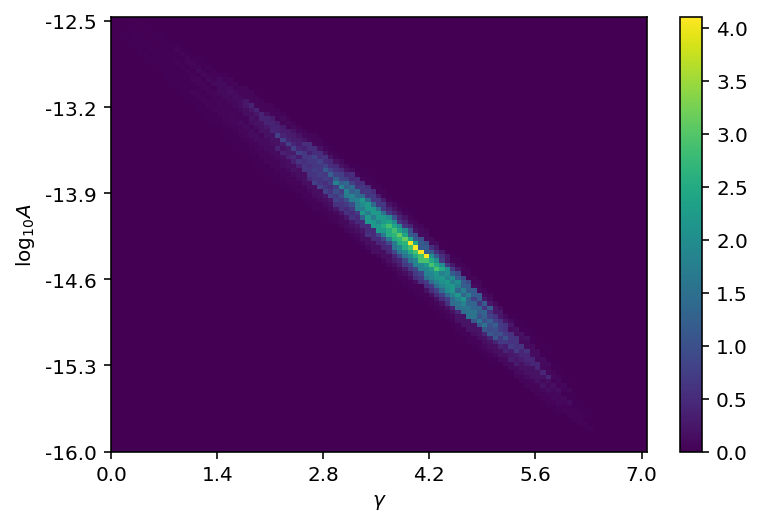

In [249]:
c = plt.pcolormesh(np.exp(log_likely_sumfreq))
plt.xticks(np.arange(101)[::20], np.round(gammas[::20],2))
plt.xlabel(r'$\gamma$')
plt.yticks(np.arange(101)[::20], log10_As[::20])
plt.ylabel(r'$\log_{10} A$')
plt.colorbar(c)

In [155]:
def log_likely(params):
    
    gamma  = params[0]
    log10A = params[1]
    
    fyr = 1.0 / 365.25 / 86400.0
    
    plaw = np.array([10**(2.0 * log10A) * (f / fyr)**(-gamma) / 12.0 / np.pi**2.0 for f in freq])
    plaw /= fyr**3.0 # psd usually given in units = (year)^3; this corrects that
    plaw *= freq[0] # this multiplies by Tspan, which is the zeroth frequnecy here
    logrho = 0.5 * np.log10(plaw)
    
    # calculate log_prob over freq
    log_prob = np.sum([rvhist[rho_labels[jj]].logpdf(logrho[jj]) for jj in range(5)], axis=0)
    
    return log_prob

In [156]:
gg, aa = np.meshgrid(gammas, log10_As)

In [158]:
mesh = log_likely([gg, aa])

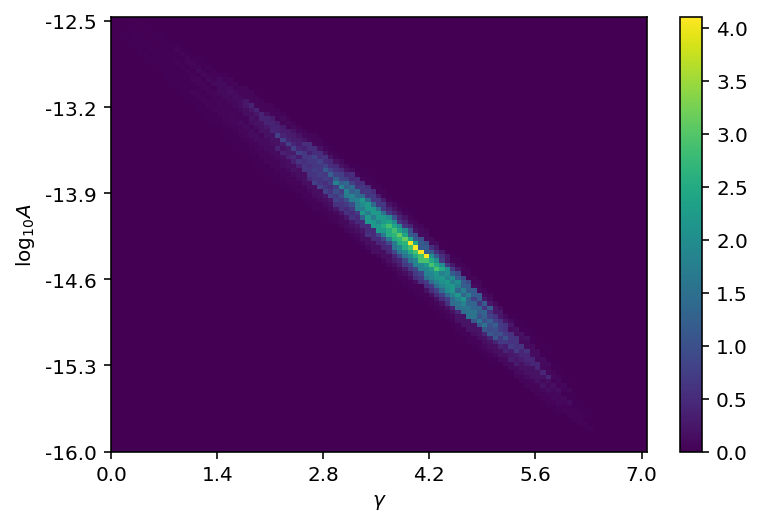

In [159]:
c = plt.pcolormesh(np.exp(mesh))
plt.xticks(np.arange(101)[::20], np.round(gammas[::20],2))
plt.xlabel(r'$\gamma$')
plt.yticks(np.arange(101)[::20], log10_As[::20])
plt.ylabel(r'$\log_{10} A$')
plt.colorbar(c)

# ptmcmc

In [53]:
ndim = 2
p0 = np.random.rand(ndim)
p0[1] = -16.+p0[1]*3
p0[0] *= 7.

In [54]:
cov = np.identity(ndim)*0.1

In [166]:
# function to calculate powerlaw at each frequency
fyr = 1.0 / 365.25 / 86400.0
freq_fyr = freq/fyr

# psd usually given in units = (year)^3; this corrects that
# this multiplies by Tspan, which is the zeroth frequnecy here
Tspan_fyr3 = freq[0]/fyr**3.0 / 12.0 / np.pi**2.0

def log_likely_mcmc(params, selected_rho, fixed_gamma=False):
    
    if fixed_gamma == True:
        gamma = 13/3
    else:
        gamma = params[0]
    
    log10A = params[1]
    
    plaw = 10**(2.0 * log10A) * freq_fyr**(-gamma)
    plaw *= Tspan_fyr3
    logrho = 0.5 * np.log10(plaw)
    
    no_freq = len(selected_rho)
    
    # calculate log_prob over freq
    log_prob = np.sum([rvhist[selected_rho[jj]].logpdf(logrho[jj]) for jj in range(no_freq)], axis=0)
    
    return log_prob

In [56]:
def log_prior(params):
    
    gamma  = params[0]
    log10A = params[1]
    
    if 0. < gamma < 7. and -16. < log10A < -12.:
        return 0.0
    else:
        return -np.inf

In [57]:
sampler = ptmcmc(ndim, log_likely_mcmc, log_prior, cov, outDir='nb_chains/sing_psr_chain/')

In [58]:
# sampler for N steps
N = 1000000
sampler.sample(p0, N)

Finished 0.40 percent in 2.693013 s Acceptance rate = 0.371253

/Users/lambwg/apps/miniconda3/envs/pta_software/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Finished 1.00 percent in 6.573337 s Acceptance rate = 0.427156Adding DE jump with weight 20
Finished 99.90 percent in 698.853384 s Acceptance rate = 0.489679
Run Complete


In [59]:
pars_mcmc = ['gamma', 'gw_log10_A', *metadata_pars]
sing_psr_samps = pd.read_csv('nb_chains/sing_psr_chain/chain_1.txt', delim_whitespace=True, header=None, names=pars_mcmc)

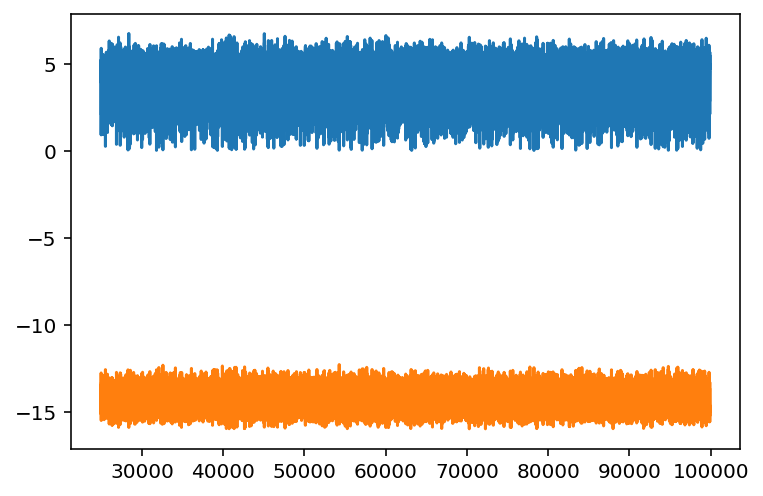

In [60]:
burn_sing_psr = int(0.25*sing_psr_samps.shape[0])

plt.plot(sing_psr_samps[burn_sing_psr:][pars_mcmc[:2]])

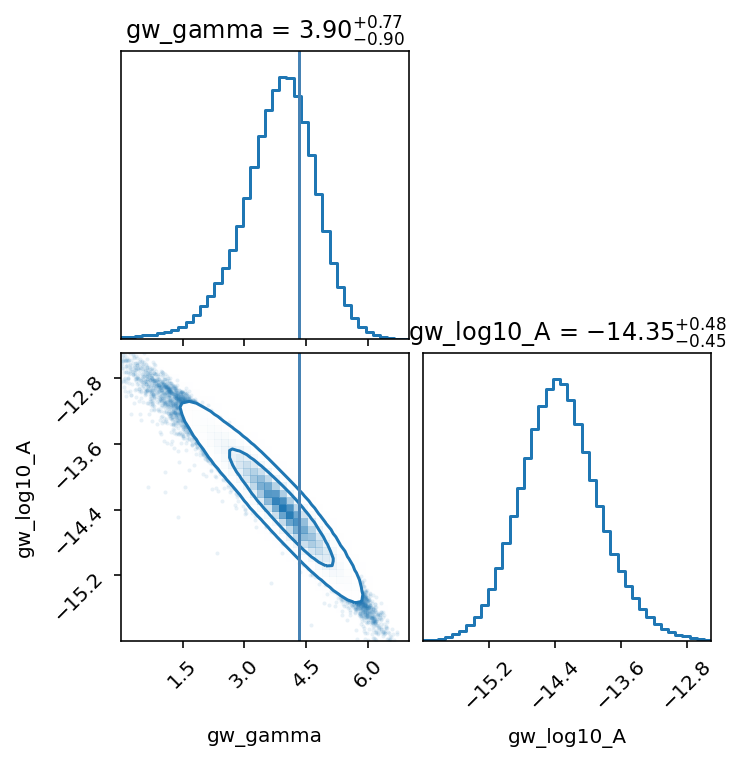

In [61]:
fig = corner.corner(
    sing_psr_samps[pars_mcmc[:2]][burn_sing_psr:], bins=40, range=[(0,7),(-16,-12.5)], labels=['gw_gamma','gw_log10_A'], truths=[13/3,None], levels=[0.68,0.95],
    smooth=True, smooth1d=True, show_titles=True, color='C0'
);

# Importing ipta_classic data

In [42]:
# list of the four model runs
models = ['model_2a_vg_cp5', 'model_2a_fg_cp5', 'model_2a_vg_cp5_bayesfm', 'model_2a_fg_cp5_bayesfm']

In [43]:
# loading parameter labels
# here we also append metadata labels
metadata_pars = ['log-likelihood', 'unweighted log-posterior', 'MCMC acceptance rate', 'interchain transitions acceptance rate']
ipta_pars = {model : np.append(np.loadtxt('../ipta_classic/' + model + '/pars.txt', dtype=np.unicode_), metadata_pars) for model in models}

In [44]:
# loading chain file and saving to dictionary. Same for burn-in index (25% of sample length)
ipta_chains = {model : pd.read_csv('../ipta_classic/' + model + '/chain_1.txt', sep='\t', dtype=float, header=None, names=ipta_pars[model], error_bad_lines=False) for model in models}
ipta_burns = {model : int(0.25*ipta_chains[model].shape[0]) for model in models}

In [47]:
# adding extra bayesfm runs
chain_fg2_bfm2 = pd.read_csv('../ipta_classic/model_2a_fg_cp5_bayesfm2/chain_1.txt', sep='\t', dtype=float, header=None, names=ipta_pars['model_2a_fg_cp5_bayesfm'], error_bad_lines=False)
chain_vg2_bfm2 = pd.read_csv('../ipta_classic/model_2a_vg_cp5_bayesfm2/chain_1.txt', sep='\t', dtype=float, header=None, names=ipta_pars['model_2a_vg_cp5_bayesfm'], error_bad_lines=False)

burn_fg_bfm2 = int(0.25*chain_fg2_bfm2.shape[0])
burn_vg_bfm2 = int(0.25*chain_vg2_bfm2.shape[0])

In [48]:
#pd.concat([chains['model_2a_fg_cp5_bayesfm'], chain_fg2_bfm2[burn_fg_bfm2:]], ignore_index=True, axis=0)
ipta_chains['model_2a_vg_cp5_bayesfm'] = pd.concat([ipta_chains['model_2a_vg_cp5_bayesfm'], chain_vg2_bfm2[burn_vg_bfm2:]], ignore_index=True, axis=0)

In [72]:
#normalisation
chosen_pars = ['gw_gamma','gw_log10_A']

samples_de = len(ipta_chains[models[0]][chosen_pars][ipta_burns[models[0]]:])
weight_de = np.ones(samples_de)/samples_de

samples_bfm = len(ipta_chains[models[2]][chosen_pars][ipta_burns[models[2]]:])
weight_bfm  = np.ones(samples_bfm)/samples_bfm

samples_single = len(sing_psr_samps[burn_sing_psr:])
weight_single = np.ones(samples_single)/(samples_single)

weights=np.ones(50000)/50000.

In [73]:
sing_psr_samps[pars_mcmc[:2]][burn_sing_psr:].shape

(74925, 2)

In [76]:
len(ipta_chains[models[0]][chosen_pars][-50000:])

50000

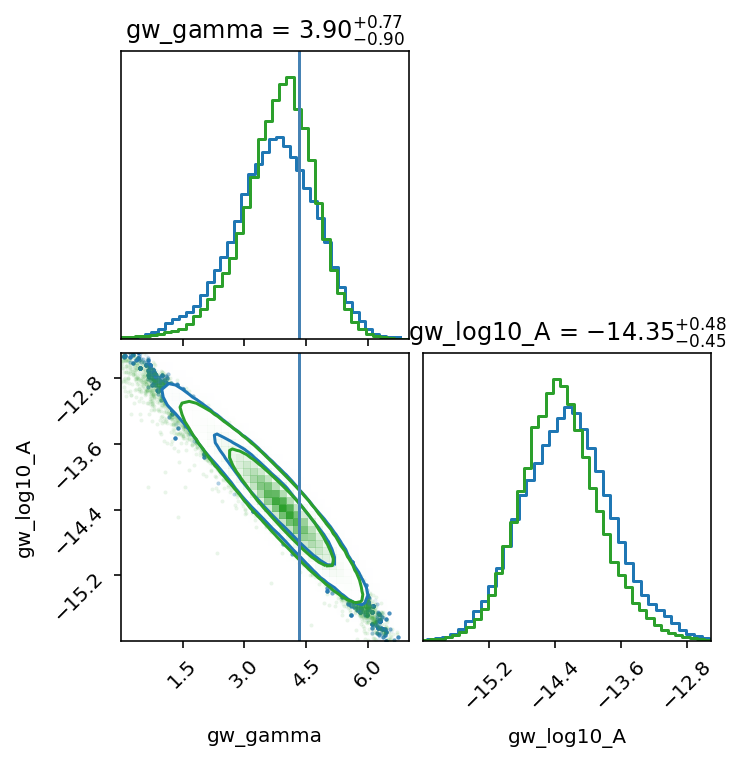

In [82]:
# corner plot test - gamma vs log10A for 
truths = [13/3,None]

fig = corner.corner(ipta_chains[models[0]][chosen_pars][ipta_burns[models[0]]:], bins=40, weights=weight_de, levels=[0.68,0.95], smooth=True, smooth1d=True, show_titles=True, truths=truths, color='C0');
#corner.corner(chains[models[2]][chosen_pars][burns[models[2]]:], bins=40, weights=weight_bfm, fig=fig, levels=[0.68,0.95], smooth=True, smooth1d=True, labels=chosen_pars, show_titles=True, truths=truths, color='C1');
corner.corner(sing_psr_samps[pars_mcmc[:2]][burn_sing_psr:], bins=40, range=[(0,7),(-16,-12.5)], weights=weight_single, fig=fig, levels=[0.68,0.95], smooth=True, smooth1d=False, labels=chosen_pars, show_titles=True, truths=truths, color='C2');

###### Fix gamma

In [85]:
ndim = 2
p0 = np.random.rand(ndim)
p0[0] *= 7
p0[1] = -16.+p0[1]*3

In [88]:
sampler = ptmcmc(ndim, log_likely_mcmc, log_prior, cov, loglkwargs={'fixed_gamma':True}, outDir='nb_chains/sing_psr_chain_fg/')

In [89]:
# sampler for N steps
N = 100000
sampler.sample(p0, N)

Finished 10.00 percent in 5.621595 s Acceptance rate = 0.44861Adding DE jump with weight 20
Finished 99.00 percent in 54.630234 s Acceptance rate = 0.518091
Run Complete


In [90]:
sing_psr_fg_samps = pd.read_csv('nb_chains/sing_psr_chain_fg/chain_1.txt', delim_whitespace=True, header=None, names=pars_mcmc)
burn_fg = int(0.25*sing_psr_fg_samps.shape[0])

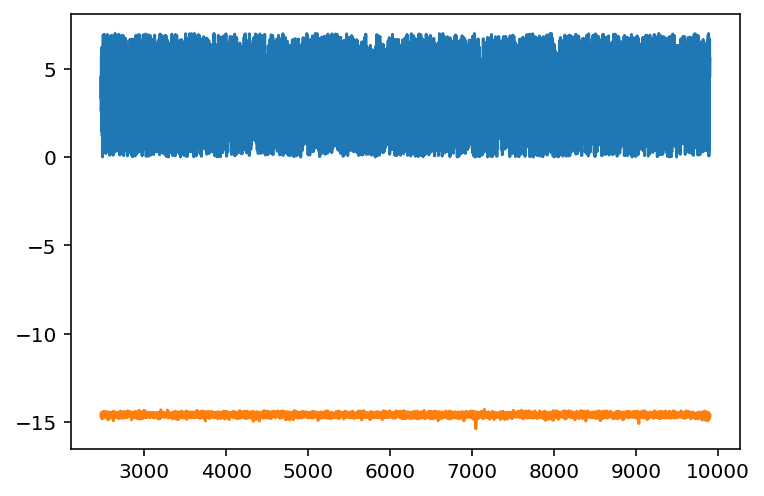

In [91]:
plt.plot(sing_psr_fg_samps[pars_mcmc[:2]][burn_fg:])

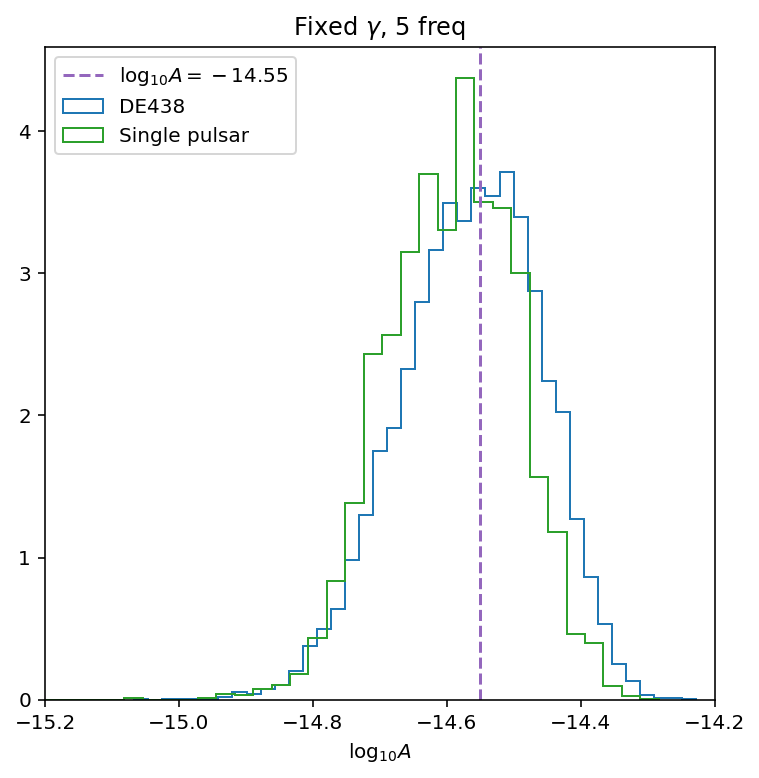

In [96]:
# plot 2d hist of gw_log10_A for DE438 vs BayesEphem
fg_models = ['model_2a_fg_cp5', 'model_2a_fg_cp5_bayesfm']
no_samples = 200000 # number of samples from the end of chain file to ensure same array shape

fig, ax = plt.subplots(figsize=(6,6))
fg1, fg2 = ipta_chains[models[1]]['gw_log10_A'][-no_samples:].to_numpy(), ipta_chains[models[3]]['gw_log10_A'][-no_samples:].to_numpy()
plt.hist(fg1, bins=40, histtype='step', density=True, label='DE438', color='C0');
#plt.hist(fg2, bins=50, histtype='step', density=True, label='BayesEphem', color='C1');
plt.hist(sing_psr_fg_samps['gw_log10_A'][burn_fg:], bins=40, histtype='step', density=True, label='Single pulsar', color='C2')
plt.axvline(-14.55, color='C4', linestyle='--', label=r'$\log_{10} A = -14.55$')
plt.xlabel(r'$\log_{10}A$')
plt.legend(loc='upper left')
plt.title(r'Fixed $\gamma$, 5 freq')
plt.xlim(-15.2, -14.2)
plt.show()

## summing logpdfs over pulsar and frequencies

In [97]:
# common set of bins across all psrs
rho_bins = np.linspace(-9, -4, num=50)

In [103]:
# form a histogram of each pulsar at each rho
epsilon = 1e-20
histograms = {rho: [np.histogram(chains[psr][rho][burns[psr]:], rho_bins, density=True)[0]+epsilon for psr in pulsar_names] for rho in rho_labels}

In [105]:
selected_pulsars = pulsar_names
hist_prod = {rho: np.prod(histograms[rho], axis=0) for rho in rho_labels}

In [109]:
# generate distribution from each rho histogram
bin_mid = (rho_bins[1:] + rho_bins[:-1]) / 2.0
rvhist_freq = {rho : scipy.stats.rv_histogram((hist_prod[rho], rho_bins)) for rho in rho_labels}

In [112]:
def rvhist_maker(selected_psr, selected_rho):
    """
        returns rv_hist objects from histograms multiplied over selected psrs for selected freqs
    """
    
    # common set of bins across all psrs
    rho_bins = np.linspace(-9, -4, num=50)
    
    # form a histogram of each pulsar at each rho
    epsilon = 1e-20
    histograms = {rho: [np.histogram(chains[psr][rho][burns[psr]:], rho_bins, density=True)[0]+epsilon for psr in selected_psr] for rho in selected_rho}
    
    ######
    
    # generate distribution from each rho histogram
    bin_mid = (rho_bins[1:] + rho_bins[:-1]) / 2.0
    rvhist_freq = {rho : scipy.stats.rv_histogram((hist_prod[rho], rho_bins)) for rho in selected_rho}
    
    return rvhist_freq

In [117]:
%timeit rvhist_maker(pulsar_names, rho_labels)

6.06 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [167]:
def run_mcmc(selected_psr, selected_rho, N, outDir, fixed_gamma=False):
    
    freqs = np.array([rho_freq[rho] for rho in selected_rho])
    no_freq = len(freqs)
    
    rvhist = rvhist_maker(selected_psr, selected_rho)

    Tspan = 952746385.6296968 # s
    inv_T = 1/Tspan
    
    ndim = 2
    p0 = np.random.rand(ndim)
    p0[0] *= 7.
    p0[1] = -16.+p0[1]*3
    
    cov = np.identity(ndim)*0.1
    
    # function to calculate powerlaw at each frequency
    fyr = 1.0 / 365.25 / 86400.0
    freq_fyr = freqs/fyr

    # psd usually given in units = (year)^3; this corrects that
    # this multiplies by Tspan, which is the zeroth frequnecy here
    Tspan_fyr3 = inv_T/fyr**3.0 / 12.0 / np.pi**2.0
    
    sampler = ptmcmc(ndim, log_likely_mcmc, log_prior, cov, outDir=outDir, loglkwargs={'selected_rho':selected_rho, 'fixed_gamma':fixed_gamma})
    
    # sampler for N steps
    sampler.sample(p0, N)

In [147]:
run_mcmc(pulsar_names, rho_labels, N=100000, outDir='nb_chains/sing_psr_chain_test/')

Finished 10.00 percent in 6.142841 s Acceptance rate = 0.47156Adding DE jump with weight 20
Finished 99.00 percent in 64.311751 s Acceptance rate = 0.487475
Run Complete


In [148]:
samps_test = pd.read_csv('nb_chains/sing_psr_chain_test/chain_1.txt', delim_whitespace=True, header=None, names=pars_mcmc)
burn_test = int(0.25*samps_test.shape[0])

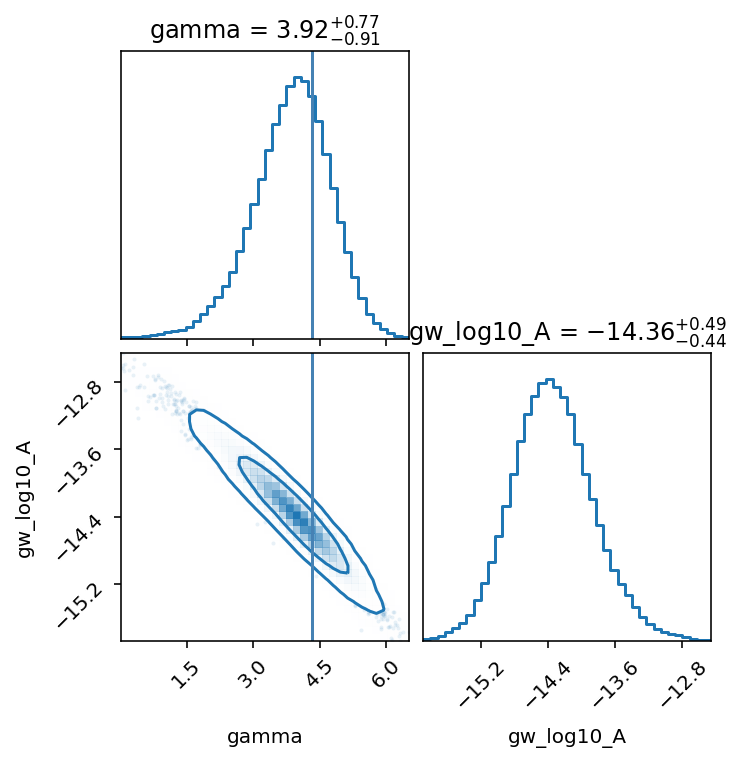

In [151]:
# corner plot test - gamma vs log10A for 
truths = [13/3,None]

fig = corner.corner(samps_test[pars_mcmc[:2]][burn_test:], bins=40, levels=[0.68,0.95], smooth=True, smooth1d=True, show_titles=True, truths=truths, color='C0');

In [169]:
rho_list = rho_labels[:2]
run_mcmc(pulsar_names, rho_list, N=100000, outDir='nb_chains/sing_psr_chain_rho/')

/Users/lambwg/apps/miniconda3/envs/pta_software/lib/python3.8/site-packages/PTMCMCSampler/PTMCMCSampler.py:494: RuntimeWarning: invalid value encountered in double_scalars
  diff = newlnprob - lnprob0 + qxy


Finished 10.00 percent in 3.376725 s Acceptance rate = 0.46212Adding DE jump with weight 20
Finished 99.00 percent in 34.857446 s Acceptance rate = 0.462545
Run Complete


In [436]:
# January
> single pulsar runs again - no common process, only search over free_spectral red-noise (30 freqs) (ipta)
